In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import tensorflow
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras.layers import LSTM
from keras.layers import Dense,Dropout,RepeatVector,Activation
from sklearn.preprocessing import StandardScaler

In [24]:
dt = pd.read_csv('AirQualityUCI.csv',delimiter=';',decimal = ',')

What do the instances that comprise the dataset represent?

0 Date	(DD/MM/YYYY)

1 Time	(HH.MM.SS)

2 True hourly averaged concentration CO in mg/m^3  (reference analyzer)

3 PT08.S1 (tin oxide)  hourly averaged sensor response (nominally  CO targeted)	

4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)

5 True hourly averaged Benzene concentration  in microg/m^3 (reference analyzer)

6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	

7 True hourly averaged NOx concentration  in ppb (reference analyzer)

8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 

9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	

10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	

11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)

12 Temperature in Â°C	

13 Relative Humidity (%) 	

14 AH Absolute Humidity

In [25]:
dt

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Prepare the Data**

In [26]:
dt = dt.drop(columns= ['Unnamed: 15','Unnamed: 16'])

In [27]:
dt.isna().sum()

Date             114
Time             114
CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
dtype: int64

**Since there are only a few N/A rows, I will remove them as they serve no purpose**

In [28]:
dt= dt.dropna()
dt

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


In [29]:
dt.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [30]:
dt['Time'].str.replace('.',':',regex= False)

0       18:00:00
1       19:00:00
2       20:00:00
3       21:00:00
4       22:00:00
          ...   
9352    10:00:00
9353    11:00:00
9354    12:00:00
9355    13:00:00
9356    14:00:00
Name: Time, Length: 9357, dtype: object

In [31]:
dt

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


In [32]:
dt['Date']=dt['Date'].str.replace('/','-')

In [33]:
train_dates = dt['Date']

In [35]:
train_dates = pd.to_datetime(dt['Date']+ " "+ dt['Time'].str.replace('.',':',regex=False))

In [36]:
dt['Date'] = train_dates

**To maintain the cyclic nature of the graph, I will transform the hours to sin(hour) cos(hour)** 

In [38]:
dt['Time']= dt['Time'].str.replace('.00.00','',regex = False).astype(float)

In [76]:
dt["t_norm"] = 2 * math.pi * dt["Time"] / dt["Time"].max()
dt['Sin Hour'] = np.sin(dt['t_norm'])
dt['Cos Hour'] = np.cos(dt['t_norm'])

In [77]:
dt= dt.sort_values(by = 'Date')

In [78]:
dt = dt.drop(columns=['t_norm'])

<AxesSubplot:xlabel='Date', ylabel='CO(GT)'>

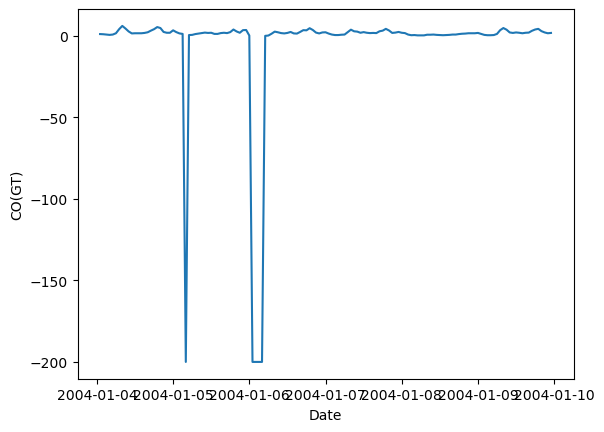

In [43]:
graph = dt.loc[(dt['Date']>'2004-01-04') & (dt['Date']<'2004-01-10')]
sns.lineplot(x = graph['Date'],y = graph['CO(GT)'])

In [45]:
dt.head(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Sin Hour,Cos Hour
510,2004-01-04 00:00:00,0.0,1.6,1143.0,106.0,6.3,825.0,96.0,986.0,86.0,1477.0,978.0,12.0,61.6,0.8593,0.000000,1.000000
511,2004-01-04 01:00:00,1.0,1.2,1044.0,100.0,5.1,770.0,85.0,1031.0,70.0,1425.0,944.0,11.5,63.9,0.8652,0.269797,0.962917
512,2004-01-04 02:00:00,2.0,1.1,1034.0,71.0,4.1,716.0,50.0,1085.0,55.0,1405.0,891.0,10.7,67.2,0.8630,0.519584,0.854419
513,2004-01-04 03:00:00,3.0,0.9,956.0,72.0,4.0,713.0,-200.0,1099.0,-200.0,1422.0,849.0,9.0,73.1,0.8394,0.730836,0.682553
514,2004-01-04 04:00:00,4.0,0.7,909.0,44.0,2.4,615.0,57.0,1237.0,49.0,1322.0,790.0,10.2,66.6,0.8299,0.887885,0.460065
515,2004-01-04 05:00:00,5.0,0.9,996.0,45.0,2.9,648.0,64.0,1176.0,50.0,1340.0,852.0,11.0,63.7,0.8325,0.979084,0.203456
516,2004-01-04 06:00:00,6.0,1.7,1154.0,134.0,7.4,876.0,153.0,1002.0,67.0,1561.0,987.0,9.6,68.8,0.8243,0.997669,-0.068242
517,2004-01-04 07:00:00,7.0,4.2,1510.0,505.0,19.8,1291.0,342.0,675.0,94.0,1949.0,1435.0,9.5,69.6,0.8273,0.942261,-0.334880
518,2004-01-04 08:00:00,8.0,6.2,1722.0,1042.0,31.9,1595.0,378.0,539.0,119.0,2439.0,1798.0,11.9,60.9,0.8455,0.816970,-0.576680
519,2004-01-04 09:00:00,9.0,4.6,1512.0,737.0,21.0,1323.0,304.0,631.0,139.0,2001.0,1677.0,16.2,48.6,0.8892,0.631088,-0.775711


In [46]:
cols_data = list(dt)[2:]
cols_data

['CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH',
 'Sin Hour',
 'Cos Hour']

In [47]:
dt_train = dt[cols_data].astype(float)

In [48]:
dt_train.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Sin Hour,Cos Hour
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604,0.000295,0.041785
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670,0.692170,0.720598
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-0.997669,-0.990686
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300,-0.631088,-0.775711
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800,0.000000,0.203456
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200,0.730836,0.854419
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,0.997669,1.000000


**Scaling The data between 0 and 1 since the values are of a extremely wide range and measurements**

In [49]:
cols_scaled = list(dt)[2:15]+ list(dt)[-6:]
scaler = StandardScaler()
scaler = scaler.fit(dt_train[cols_scaled])
dt_train_scaled= scaler.transform(dt_train[cols_scaled])


In [52]:
dt_train_scaled.shape

(9357, 19)

In [53]:
Xtrain = []
Ytrain = []
timesteps = 6
future_days = 1

**Create a "sliding window" of values using past days as an interval for the 13 columns**

In [54]:
for i in range(timesteps, len(dt_train_scaled)- future_days+1):
    Xtrain.append(dt_train_scaled[i-timesteps:i,0:dt_train_scaled.shape[1]])
    Ytrain.append(dt_train_scaled[i+future_days-1:i+future_days,0])
    

In [55]:
trainX, trainY = np.array(Xtrain),np.array(Ytrain)

**You can see how Ytrain is taking the next interval of 6 after every 12 days**

In [59]:
print('Shape of train X {}',trainX.shape)
print('Shape of train Y {}',trainY.shape)

Shape of train X {} (9351, 6, 19)
Shape of train Y {} (9351, 1)


**Creating the Model**

In [60]:
model = Sequential()
model.add(LSTM(64,activation = 'relu',input_shape = (trainX.shape[1],trainX.shape[2]), return_sequences= True))
model.add(LSTM(32,activation = 'relu', return_sequences= False))
model.add(Dropout(.5))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer = 'adam',loss= 'mse')

Metal device set to: Apple M1 Pro


2022-09-06 20:53:43.675570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-06 20:53:43.675770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [61]:
results = model.fit(trainX, trainY, epochs = 25, batch_size = 64,validation_split=.1,verbose = 1)

Epoch 1/25


2022-09-06 20:53:44.620212: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-06 20:53:45.738406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - ETA: 0s - loss: 0.5312

2022-09-06 20:54:07.627985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 23s 147ms/step - loss: 0.5312 - val_loss: 0.1323
Epoch 2/25
132/132 [==============================] - 19s 146ms/step - loss: 0.3457 - val_loss: 0.1233
Epoch 3/25
132/132 [==============================] - 19s 141ms/step - loss: 0.2888 - val_loss: 0.1158
Epoch 4/25
132/132 [==============================] - 18s 140ms/step - loss: 0.2682 - val_loss: 0.1111
Epoch 5/25
132/132 [==============================] - 19s 142ms/step - loss: 0.2707 - val_loss: 0.1131
Epoch 6/25
132/132 [==============================] - 19s 142ms/step - loss: 0.2571 - val_loss: 0.1192
Epoch 7/25
132/132 [==============================] - 19s 142ms/step - loss: 0.2546 - val_loss: 0.1133
Epoch 8/25
132/132 [==============================] - 18s 139ms/step - loss: 0.2511 - val_loss: 0.1162
Epoch 9/25
132/132 [==============================] - 19s 141ms/step - loss: 0.2480 - val_loss: 0.1151
Epoch 10/25
132/132 [==============================] - 19s 142ms/step - loss: 0.2425

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 64)             21504     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 33,953
Trainable params: 33,953
Non-trainable params: 0
_________________________________________________________________


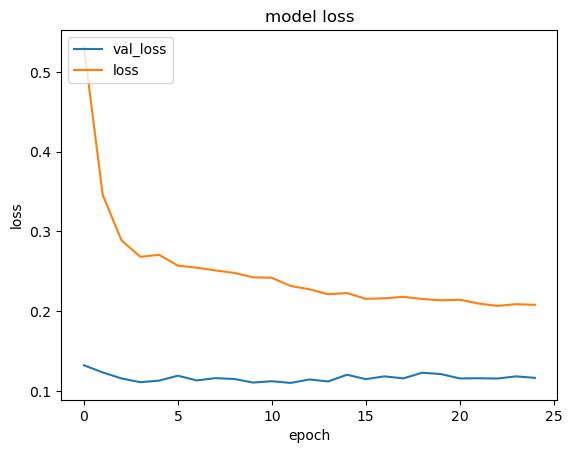

In [63]:
plt.plot(results.history['val_loss'])
plt.plot(results.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

**Forecasting the future**

In [70]:
future_hours = 200
future_dates = pd.date_range(list(train_dates)[-1],periods = future_hours, freq = '1H').tolist()
forecast= model.predict(trainX[-future_hours:])

7/7 [==============================] - 0s 14ms/step


In [71]:
forecast_copies = np.repeat(forecast,len(cols_scaled),axis=-1)
ypred = scaler.inverse_transform(forecast_copies)[:,0]

In [73]:
fdates= [] 
for t in future_dates:
    fdates.append(t)
finaldt= pd.DataFrame({'Date':np.array(fdates),'CO(GT)':ypred})
finaldt['Date']=pd.to_datetime(finaldt['Date'])


<AxesSubplot:xlabel='Date', ylabel='CO(GT)'>

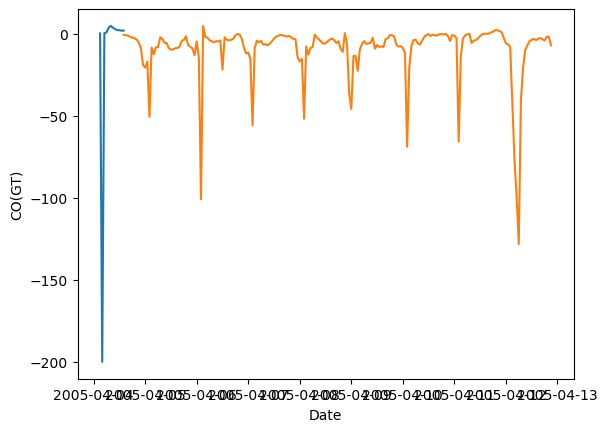

In [75]:
graph_dt =dt.loc[(dt['Date']>'2005-04-04 02:00:00') & (dt['Date']<'2005-04-04 15:00:00')]
sns.lineplot(x = graph_dt['Date'],y = graph_dt['CO(GT)'])
sns.lineplot(x = finaldt['Date'],y = finaldt['CO(GT)'])
